In [1]:
# Class weight a typical method. We'll use a different method now.
# We will use focal loss.

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.rcParams["figure.figsize"] = (12,8)

print(f"Version: {tf.__version__}")

Version: 2.10.1


# Import data

In [3]:
url = "https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip"

df = pd.read_csv(url, compression='zip')
df.shape

(1306122, 3)

In [4]:
df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


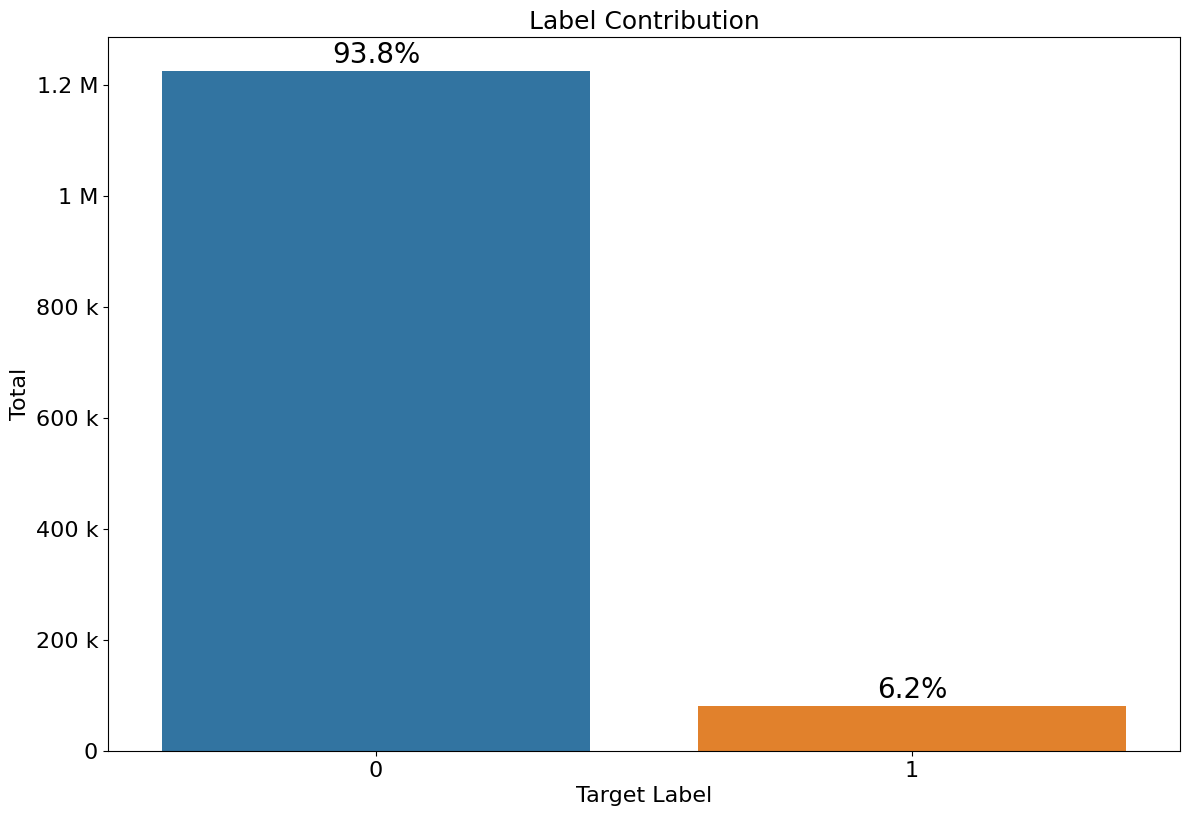

In [5]:
ax = sns.countplot(data = df, x = 'target')

plt.xticks(size = 16)
plt.xlabel("Target Label" , size = 16)
plt.yticks(size = 16)
plt.ylabel('Total', size = 16)
ax.yaxis.set_major_formatter(ticker.EngFormatter())

ax.set_xticklabels(ax.get_xticklabels(), ha='center' )
total = len(df)

for p in ax.patches : 
    perc = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(perc , (x,y) , ha="center", va = 'center' , fontsize = 20)

plt.tight_layout()
plt.title('Label Contribution' , fontsize = 18)
plt.show()

# TF.Data Pipeline

In [6]:
feats, labels = df['question_text'] , df['target']

In [8]:
trainVal_feats , X_test, trainVal_labels , y_test = train_test_split(feats , labels, test_size= 0.2, stratify= labels, random_state= 53)

In [10]:
trainVal_feats.shape , trainVal_labels.shape

((1044897,), (1044897,))

In [9]:
X_train , X_val , y_train , y_val = train_test_split(
                                                    trainVal_feats ,
                                                    trainVal_labels , 
                                                    train_size = 0.8 , 
                                                    stratify= trainVal_labels ,
                                                    random_state= 53                                             
                                                    
)

In [11]:
X_train.shape , y_train.shape

((835917,), (835917,))

In [21]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)) # You can use tf.data.Dataset.from_generator() for bigger data. You can save RAM with this way.
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [22]:
train_ds

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [23]:
next(iter(train_ds))

(<tf.Tensor: shape=(), dtype=string, numpy=b'This happened to medo teachers sometimes lose trust in their student if the student has told them something (like if they self harm or starve or etc)?'>,
 <tf.Tensor: shape=(), dtype=int64, numpy=0>)

In [24]:
train_ds = train_ds.shuffle(4096).batch(2048, drop_remainder= False).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(2048).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(2048).prefetch(tf.data.AUTOTUNE)

In [25]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# Create Model

In [12]:
embedding_link = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"

embedding = hub.KerasLayer(
    embedding_link
)

In [26]:
embedding

In [30]:
sample = tf.constant(['hi guys bro' , 'Hello my friend how are you'])
sample

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'hi guys bro', b'Hello my friend how are you'], dtype=object)>

In [ ]:
# embedding(sample)

In [51]:
input_layer = tf.keras.Input(batch_input_shape = (None, ), dtype = tf.string)
embedding_output = embedding(input_layer)

# 1.branch
x = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis= -1))(embedding_output)
x = tf.keras.layers.Conv1D(filters = 16, kernel_size= 5)(x)
x = tf.nn.silu(x)
x = tf.keras.layers.AveragePooling1D()(x)
x = tf.keras.layers.Conv1D(filters= 32 , kernel_size= 3)(x)
x = tf.nn.silu(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)

# 2.branch
y = tf.keras.layers.Dense(128)(embedding_output)
y = tf.nn.silu(y)

merged = tf.keras.layers.Concatenate()([x, y])

final_layer = tf.keras.layers.Dense(1)(merged)
final_layer = tf.nn.sigmoid(final_layer)

model_normal = tf.keras.Model(input_layer, final_layer)

In [52]:
tf.keras.utils.plot_model(model_normal, show_shapes= True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [69]:
model_normal.layers[1].trainable = True

In [70]:
model_normal.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       (None, 128)          124642688   ['input_15[0][0]']               
                                                                                                  
 lambda_11 (Lambda)             (None, 128, 1)       0           ['keras_layer[13][0]']           
                                                                                                  
 conv1d_21 (Conv1D)             (None, 124, 16)      96          ['lambda_11[0][0]']              
                                                                                            

In [55]:
# model_focal = tf.keras.models.clone_model(model_normal) # When you clone a model in this way, weights don't save.

In [66]:
# model_normal.save_weights("starting_point.h5") # We got our weights now

In [74]:
model_normal.compile(optimizer= 'adam',
                     loss = tf.keras.losses.BinaryCrossentropy(),
                     metrics = [tf.keras.metrics.TruePositives(),
                                tf.keras.metrics.FalseNegatives()])

In [75]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    min_lr = 1e-8, verbose= 1 , patience= 3
)

model_normal.fit(train_ds, validation_data= val_ds , epochs = 32, callbacks=[reduce_lr])

Epoch 1/32
409/409 [==============================] - 18s 33ms/step - loss: 0.1634 - true_positives_1: 15682.0000 - false_negatives_1: 36036.0000 - val_loss: 0.1263 - val_true_positives_1: 5274.0000 - val_false_negatives_1: 7656.0000 - lr: 0.0010
Epoch 2/32
409/409 [==============================] - 13s 31ms/step - loss: 0.1156 - true_positives_1: 24278.0000 - false_negatives_1: 27440.0000 - val_loss: 0.1242 - val_true_positives_1: 5716.0000 - val_false_negatives_1: 7214.0000 - lr: 0.0010
Epoch 3/32
409/409 [==============================] - 13s 32ms/step - loss: 0.1071 - true_positives_1: 27124.0000 - false_negatives_1: 24594.0000 - val_loss: 0.1267 - val_true_positives_1: 6088.0000 - val_false_negatives_1: 6842.0000 - lr: 0.0010
Epoch 4/32
409/409 [==============================] - 14s 33ms/step - loss: 0.1002 - true_positives_1: 29019.0000 - false_negatives_1: 22699.0000 - val_loss: 0.1320 - val_true_positives_1: 6329.0000 - val_false_negatives_1: 6601.0000 - lr: 0.0010
Epoch 5/32
4

In [76]:
from sklearn.metrics import classification_report, confusion_matrix

In [82]:
# model_normal(np.array([['Hi']])).numpy()

array([[0.00017122]], dtype=float32)

In [91]:
def eval_model(
                model,
                threshold,
                dataset
               ):
    y_pred = []
    y_true = []
    
    for x, y in dataset:
        y_pred.append(model(x).numpy())
        y_true.append(y.numpy())
        
    y_pred = np.concatenate(y_pred, axis = 0)
    y_true = np.concatenate(y_true, axis = 0)
    
    y_pred = np.where(y_pred > threshold, 1 ,0)
    
    print(classification_report(y_true , y_pred, digits=4))
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot = True , fmt= ".4f")
    plt.show()

              precision    recall  f1-score   support

           0     0.9763    0.9639    0.9701    245063
           1     0.5413    0.6460    0.5890     16162

    accuracy                         0.9442    261225
   macro avg     0.7588    0.8049    0.7795    261225
weighted avg     0.9494    0.9442    0.9465    261225



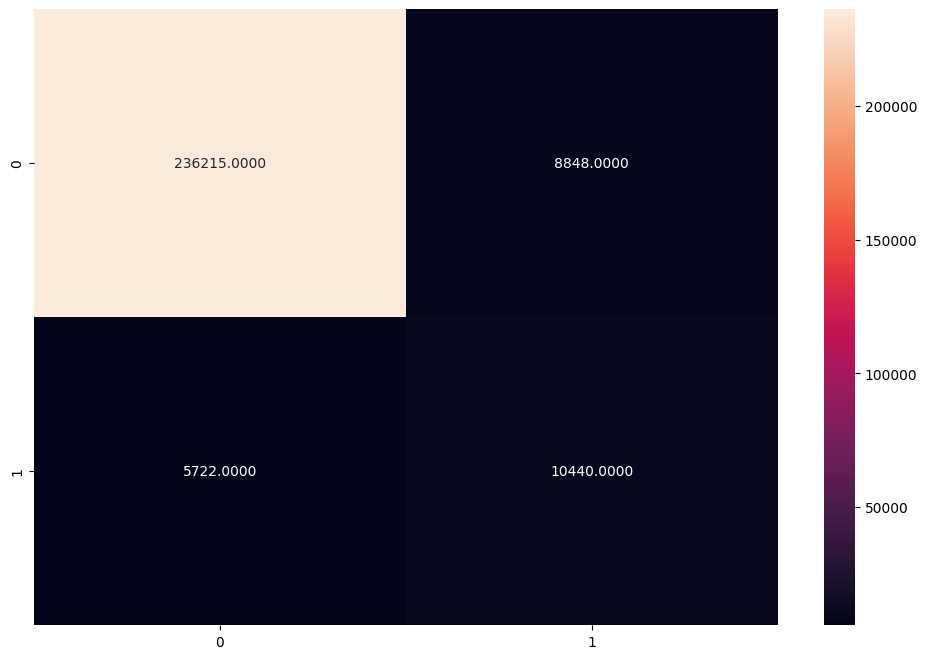

In [93]:
eval_model(model_normal , 0.3 , test_ds)

# 2.Model

In [95]:
model_focal.load_weights("starting_point.h5")

In [96]:
model_focal.compile(optimizer= 'adam',
                     loss = tf.keras.losses.BinaryFocalCrossentropy(),
                     metrics = [tf.keras.metrics.TruePositives(),
                                tf.keras.metrics.FalseNegatives()])

In [97]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    min_lr = 1e-8, verbose= 1 , patience= 3
)

model_focal.fit(train_ds, validation_data= val_ds , epochs = 32, callbacks=[reduce_lr])

Epoch 1/32
409/409 [==============================] - 7s 15ms/step - loss: 0.0483 - true_positives_2: 9328.0000 - false_negatives_2: 42390.0000 - val_loss: 0.0406 - val_true_positives_2: 3265.0000 - val_false_negatives_2: 9665.0000 - lr: 0.0010
Epoch 2/32
409/409 [==============================] - 6s 14ms/step - loss: 0.0405 - true_positives_2: 13990.0000 - false_negatives_2: 37728.0000 - val_loss: 0.0403 - val_true_positives_2: 3185.0000 - val_false_negatives_2: 9745.0000 - lr: 0.0010
Epoch 3/32
409/409 [==============================] - 6s 14ms/step - loss: 0.0402 - true_positives_2: 14188.0000 - false_negatives_2: 37530.0000 - val_loss: 0.0399 - val_true_positives_2: 3409.0000 - val_false_negatives_2: 9521.0000 - lr: 0.0010
Epoch 4/32
409/409 [==============================] - 6s 14ms/step - loss: 0.0399 - true_positives_2: 14360.0000 - false_negatives_2: 37358.0000 - val_loss: 0.0396 - val_true_positives_2: 3687.0000 - val_false_negatives_2: 9243.0000 - lr: 0.0010
Epoch 5/32
409/40

              precision    recall  f1-score   support

           0     0.9865    0.8901    0.9358    245063
           1     0.3284    0.8149    0.4682     16162

    accuracy                         0.8854    261225
   macro avg     0.6574    0.8525    0.7020    261225
weighted avg     0.9458    0.8854    0.9069    261225



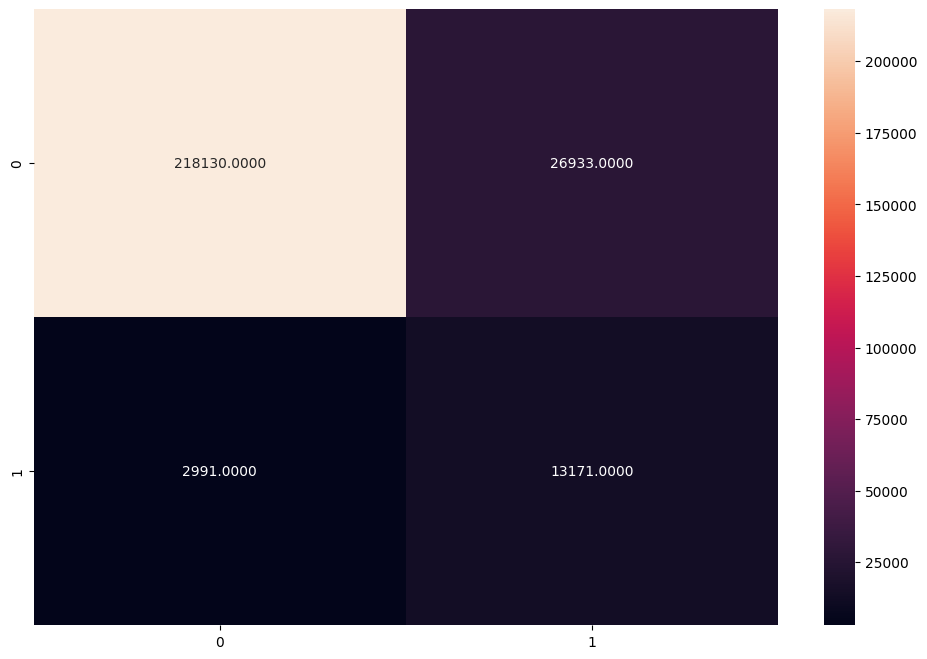

In [100]:
eval_model(model_focal,
           0.3,
           test_ds)

# Loss Comparisions

In [110]:
bce_loss = tf.keras.losses.BinaryCrossentropy(reduction= 'none')
bfce_loss = tf.keras.losses.BinaryFocalCrossentropy(reduction= 'none')

In [111]:
y_pred = np.array([[0.1], [0.9], [0.2], [0.3]])
y_true = np.array([[0.0], [1.0], [1.0], [0.0]])

In [112]:
bce_loss(y_pred, y_true)

<tf.Tensor: shape=(4,), dtype=float64, numpy=array([ 1.54249485,  1.54249485, 12.33995878,  4.62748454])>

In [113]:
bfce_loss(y_pred, y_true) # Focal Loss punish very hard for your wrongs... Most of time its better for imbalanced data.

<tf.Tensor: shape=(4,), dtype=float64, numpy=array([0.01542495, 0.01542495, 7.89757362, 0.41647361])>

In [ ]:
# Done